In [0]:
# Source of KNN code: https://towardsdatascience.com/k-nearest-neighbor-python-2fccc47d2a55

In [2]:
!pip install hdf5storage

     |████████████████████████████████| 61kB 4.7MB/s 


In [3]:
!pip install mat73

  Created wheel for mat73: filename=mat73-0.38-cp36-none-any.whl size=3985 sha256=f8dd2e868920320eae88f99d36fe95f895f0e8515ef88dd75bf3db5dd93d66fa
  Stored in directory: /root/.cache/pip/wheels/8e/0c/c0/95e8b92b733a980785ee55988777ef2c5a85c6fa9a2c8f2f94
Successfully built mat73


In [0]:
import os
import random
import h5py
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import hdf5storage
from IPython.core.display import Image, display
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
from numpy import ma
import scipy.io as sio
from IPython.display import Image
from matplotlib import cm as CM

In [0]:
# Added for KNN
#import numpy as np
import pandas as pd
import sklearn
#from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
#import seaborn as sns
#sns.set()

In [0]:
import mat73
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers 
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [7]:
Data_Foldername = '/content/drive/My Drive/Indoor_Positioning_Data'

Meas_Comb_h =    "%s/h_Estimated_CTW_Train.mat" % (Data_Foldername)
Meas_Comb_r =    "%s/r_Position_CTW_Train.mat" % (Data_Foldername)
Meas_Comb_SNR =   "%s/SNR_CTW_Train.mat" % (Data_Foldername)
# Traniningsize 
TrainingsSize = 0.9# 90 %
channel_r=hdf5storage.loadmat(Meas_Comb_r)
channel_h=hdf5storage.loadmat(Meas_Comb_h)
h_estimated=channel_h['h_Estimated']
h_estimated = np.abs(h_estimated)
r_estimated=channel_r['r_Position']
print("shape of h_estimated:",  h_estimated.shape)
print("shape of r_estimated:",  r_estimated.shape)

shape of h_estimated: (17486, 16, 924)
shape of r_estimated: (17486, 3)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  import sys


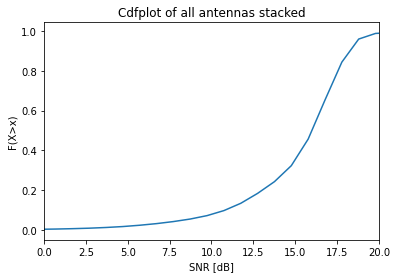

In [0]:
# Example for Measurement Quality
SNR_Mat = hdf5storage.loadmat(Meas_Comb_SNR)
SNR_Meas = np.transpose(SNR_Mat['SNR_Est'])


num_bins = 50
# Use the histogram function to bin the data
counts, bin_edges = np.histogram(SNR_Meas, bins=num_bins, normed=True)

# Now find the cdf
cdf = np.cumsum(counts)

# And finally plot the cdf
plt.plot(bin_edges[1:], cdf)
plt.xlim(0, 20)
plt.xlabel('SNR [dB]')
plt.ylabel('F(X>x)')
plt.title('Cdfplot of all antennas stacked')
plt.show()

In [0]:

"""
## Input Settings ########################################
# NN Settings
nb_epoch =50                           # number of learning epochs
batch_sizes = [8,64,128,256,1024]             # size of batches for calculation the gradient

# Number of Antennas 
Nb_Antennas = [2,4,8,16]
"""
# OutputName
Filename_Pre = '/content/drive/My Drive/Indoor_Positioning_Data/Results/';

# Mean_Error_Train = np.empty([len(Nb_Antennas)])
# Mean_Error_Test = np.empty([len(Nb_Antennas)])
# Schuffle
shuffling_index =random.sample(range(r_estimated[:,0].size),r_estimated[:,0].size);
h_estimated = h_estimated[shuffling_index,:,:]
r_estimated =  r_estimated[shuffling_index,:]
    
# Split Data
h_estimated_train_saved = h_estimated[0:int(TrainingsSize*r_estimated[:,0].size),:,:] # x_train
x_train = h_estimated_train_saved
Positions_train =   r_estimated[0:int(TrainingsSize*r_estimated[:,0].size),:] # y_train
y_train = Positions_train
h_estimated_test_saved =  h_estimated[int(TrainingsSize*r_estimated[:,0].size):,:] # x_test
x_test = h_estimated_test_saved
Positions_test =    r_estimated[int(TrainingsSize*r_estimated[:,0].size):,:] # y_test
y_test = Positions_test

# shuffling done already, no need of: X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

Length_Test = len(Positions_test[:,0]) # no of items in test dataset

In [0]:
def dist(y_true, y_pred):    # to calculate distance
    return tf.reduce_mean((tf.sqrt(tf.square(tf.abs(y_pred[:,0]-y_true[:,0]))+tf.square(tf.abs(y_pred[:,1]-y_true[:,1]))+tf.square(tf.abs(y_pred[:,2]-y_true[:,2])))))

def true_dist(y_true, y_pred):    # to calculate true distance
    return (np.sqrt(np.square(np.abs(y_pred[:,0]-y_true[:,0]))+np.square(np.abs(y_pred[:,1]-y_true[:,1]))+np.square(np.abs(y_pred[:,2]-y_true[:,2]))))

In [13]:
x_train=x_train.reshape((x_train.shape[0],-1))
x_train.shape

(15737, 14784)

In [14]:
y_train.shape

(15737, 3)

In [15]:
x_test=x_test.reshape((x_test.shape[0],-1))
x_test.shape

(1749, 14784)

In [22]:
# Defining knn:
knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=10, metric='euclidean')
# training knn:
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [0]:
# predict using knn
y_pred = knn.predict(x_test)

Mean error on Test  area: 0.32640131431246844


Text(0.5, 1.0, '10-KNN Error Distribution')

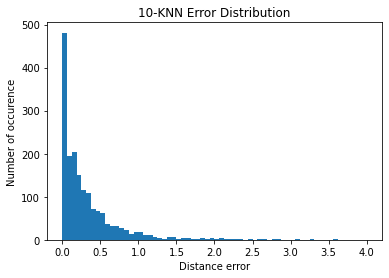

In [24]:
# Histogramm of errors on test Area
errors = true_dist(y_pred , y_test)
Mean_Error_Test = np.mean(np.abs(errors))
print("Mean error on Test  area:",Mean_Error_Test)
plt.hist(errors,bins=64,range=(0,4))
plt.ylabel('Number of occurence')
plt.xlabel('Distance error')
plt.title('10-KNN Error Distribution')

In [0]:
import pickle
with open('KNN_abs_h_10_error', 'wb') as f:
    pickle.dump(errors, f)

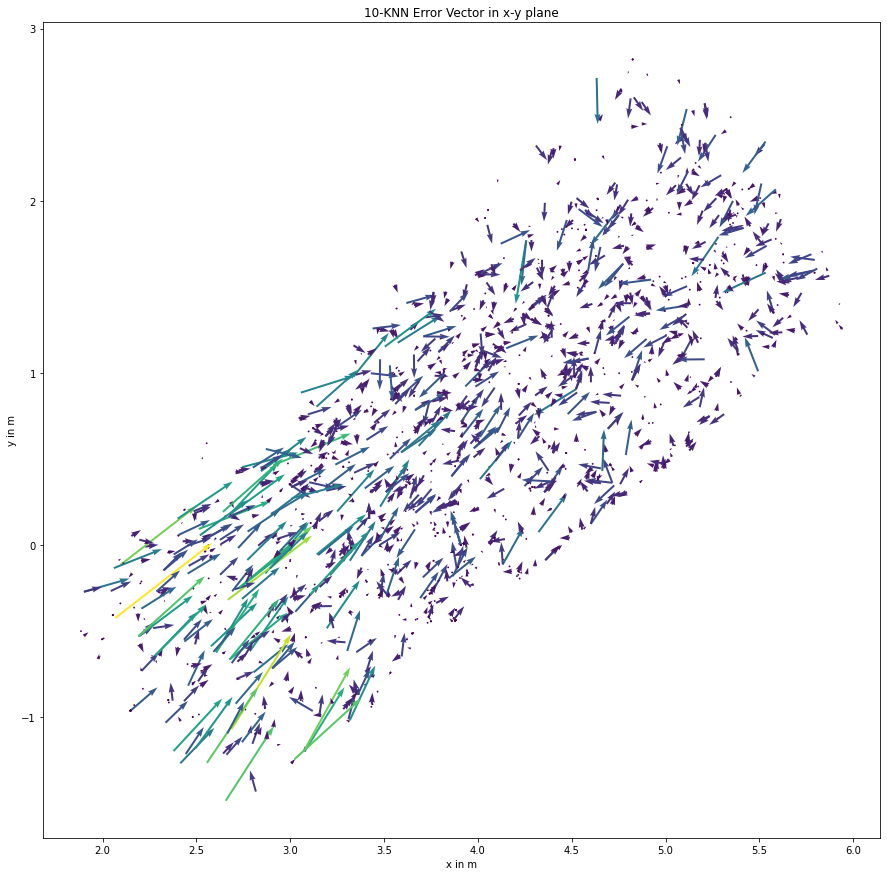

In [26]:
# Error Vector over Area in XY
error_vectors = np.real(y_pred - y_test)
plt.figure(figsize=(15,15))
plt.quiver(np.real(y_test[:,0]),np.real(y_test[:,1]),error_vectors[:,0],error_vectors[:,1],errors)
plt.xlabel("x in m")
plt.ylabel("y in m")
plt.title('10-KNN Error Vector in x-y plane')
plt.show()